In [16]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 0


In [17]:
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"].values
X_val   = data["X_val"].values
X_test  = data["X_test"].values
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]
test_dates = data["test_dates"]
scaler  = data["scaler"]
y_scaler = data["scaler_y"]

y_test.shape

(213661, 1)

In [18]:
sequence_length = 1

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, sequence_length)


print(X_train_seq.min(), X_train_seq.max(), X_train_seq.std())
print(y_train_seq.min(), y_train_seq.max(), y_train_seq.std())


0.0 1.0000000000000002 0.22992912069850605
0.0 1.0 0.20562468980644105


In [19]:


model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [20]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

class PredictionHistory(Callback):
    def __init__(self, X_train_seq, y_train_seq, y_scaler):
        super().__init__()
        self.X_train_seq = X_train_seq
        self.y_train_seq = y_train_seq
        self.y_scaler = y_scaler
        self.predictions_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict on the training set
        pred_scaled = self.model.predict(self.X_train_seq, verbose=0)
        pred_inv = self.y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
        self.predictions_per_epoch.append(pred_inv)

        # Compute RMSE for monitoring
        actual = self.y_scaler.inverse_transform(self.y_train_seq.reshape(-1,1)).flatten()
        rmse = np.sqrt(np.mean((actual - pred_inv)**2))
        print(f"Epoch {epoch+1} - Train RMSE: {rmse:.4f}")


Epoch 1/20
31132/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0253Epoch 1 - Train RMSE: 0.9202
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.0220 - val_loss: 0.0391
Epoch 2/20
31119/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0196Epoch 2 - Train RMSE: 0.9222
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - loss: 0.0192 - val_loss: 0.0393
Epoch 3/20
31150/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185Epoch 3 - Train RMSE: 0.9276
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - loss: 0.0183 - val_loss: 0.0398
Epoch 4/20
31126/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179Epoch 4 - Train RMSE: 0.9319
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.0177 - val_loss: 0.0402
Epoch 5/20
31158/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175Epoch 5 - Train RMSE: 0.9309
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - loss: 0.0173 - val_loss: 0.0402
Epoch 6/20
31137/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172Epoch 6 - Train RMSE: 0.9237
311

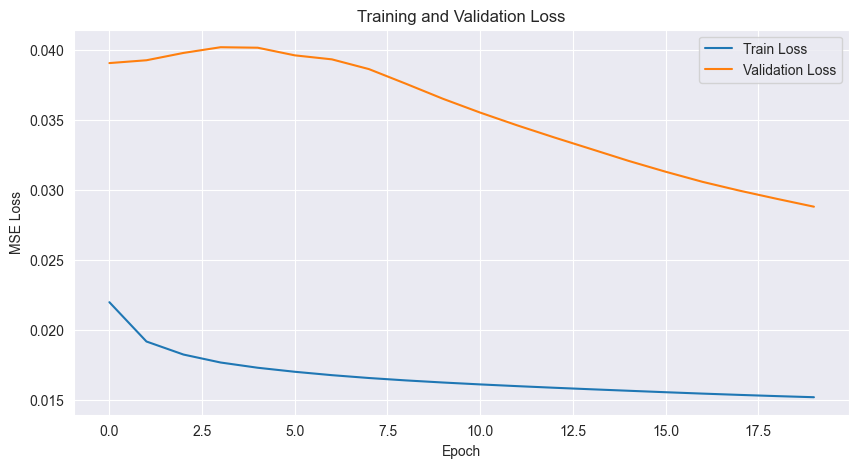

In [21]:

callback = PredictionHistory(X_train_seq, y_train_seq, y_scaler)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    shuffle=False,
    callbacks=[callback]
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


C:\Users\Patrick\PycharmProjects\PythonProject1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


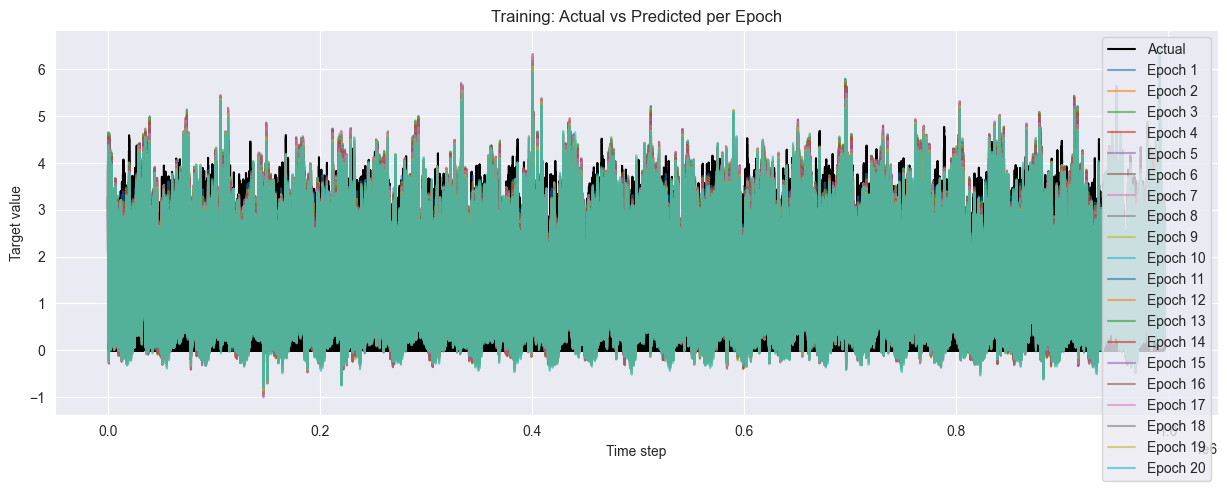

In [22]:
actual = y_scaler.inverse_transform(y_train_seq.reshape(-1,1)).flatten()

plt.figure(figsize=(15,5))
plt.plot(actual, label="Actual", color='black')

# Plot predictions for each epoch
for i, pred in enumerate(callback.predictions_per_epoch):
    plt.plot(pred, label=f"Epoch {i+1}", alpha=0.6)

plt.xlabel("Time step")
plt.ylabel("Target value")
plt.title("Training: Actual vs Predicted per Epoch")
plt.legend()
plt.show()


In [23]:
pred_scaled = model.predict(X_test_seq)

print(pred_scaled)
print(X_test_seq)
# Inverse scale both prediction and ground truth
pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
print(actual.min(), actual.max(), actual.std())

# Compute RMSE
rmse = np.sqrt(np.mean((actual - pred)**2))
print(f"RMSE: {rmse:.4f}")

6677/6677 ━━━━━━━━━━━━━━━━━━━━ 5s 677us/step
[[0.06402501]
 [0.04317215]
 [0.06214948]
 ...
 [0.24667443]
 [0.24048981]
 [0.2333368 ]]
[[[0.51757188 0.45529801 0.43066884 ... 0.36170213 0.37837838 0.29832936]]

 [[0.50638978 0.46688742 0.43882545 ... 0.46808511 0.43243243 0.30310263]]

 [[0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]]

 ...

 [[0.48083067 0.52649007 0.56606852 ... 0.46808511 0.21621622 0.98926014]]

 [[0.48242812 0.52152318 0.56117455 ... 0.4893617  0.27027027 0.99045346]]

 [[0.48402556 0.52649007 0.56769984 ... 0.44680851 0.21621622 0.99403341]]]
0.0 4.409033640160408 0.9858862280925679
RMSE: 0.7982


[0.30488184 0.20558222 0.29595068 ... 1.1746433  1.1451926  1.1111306 ]


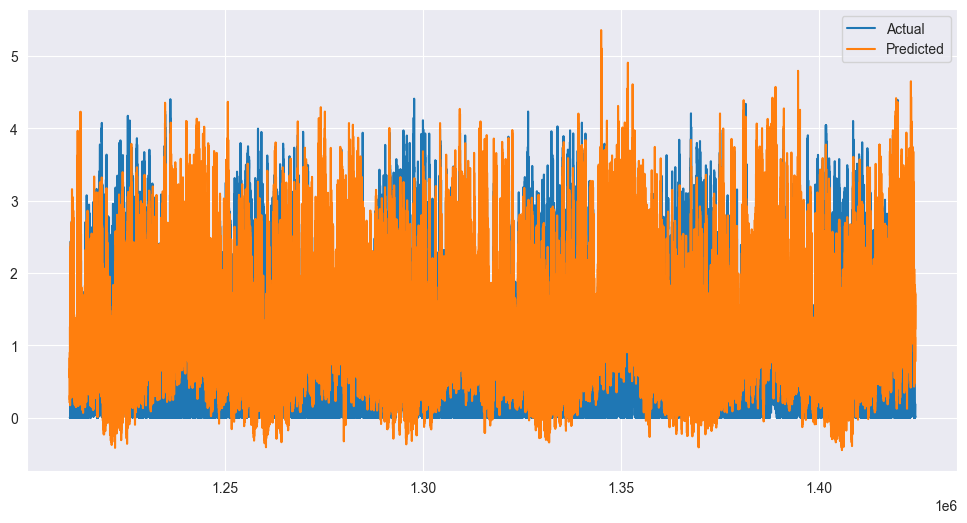

In [24]:
print(pred)
plt.figure(figsize=(12, 6))
plt.plot(test_dates[sequence_length:], actual, label='Actual')
plt.plot(test_dates[sequence_length:], pred, label='Predicted')
plt.legend()
plt.grid(True)
plt.show()

